Удалила "2 Зрелый почерк-(обычный почерк)-2.jpg" (там печатный текст)

# Config

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/Colab\ Notebooks/mest

/content/drive/MyDrive/Colab Notebooks/mest


In [3]:
!pip install -q hydra-core==1.3
# https://colab.research.google.com/gist/fabiocarrara/6bf5abaecf3f84c1e83239f8af3b8219/hydra_instantiate_bug.ipynb

# Библиотеки

In [4]:
import json, os
import matplotlib.pyplot as plt

from torchvision import datasets, models, transforms
from time import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.transforms import v2
from PIL import Image, ImageOps
from tqdm import tqdm

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch
import os, json, cv2, re
import numpy as np
import random

from src.dataset import My_Dataset, TripletDataset, Emb_Dataset
from src.functions import number_of_parameters, seed_everything # create_model
from src.dataset_fun import split_dataset
from src import siamese, classifier
from src.classifier import get_predictions
from src.train import train, load_logs, load_model
from src.functions import confusion_matrix, distribution
from src.show_fun import show_result, show_images, plot_transformed_images

from src.commands import hydra_config, show_CONF, config_model
from src.commands import common_train, load_best_model, pos_neg_dataset

In [ ]:
# transform = transforms.Compose(
#         [
#             transforms.RandomCrop(300),
#             transforms.CenterCrop(224),
#             transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=255),
#             transforms.ToTensor(),
#             # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#         ]
#     )


# files = os.listdir("bin/1")
# files = [os.path.join("bin/1", i) for i in files]
# plot_transformed_images(files, transform, n=10)

def show_voting(model,
    dataset,
    aug,
    batch_size,
    device):

    X, y_true, y_pred, y_prob = get_predictions(model, dataset, batch_size, device)

    height = len(dataset) // aug
    # width = aug
    # print(height, aug)

    for i in range(height):

        X_cur = X[i::height]
        y_prob_cur = y_prob[i::height]

        width = len(X_cur)
        plt.figure(figsize=(6.4 * width, 6))

        for j in range(width):
            plt.subplot(1, width, j % width + 1)
            img = X_cur[j]
            img = np.transpose(img, (1, 2, 0))

            title = f"№ {i}:   {y_prob_cur[j]}"
            plt.title(title)
            plt.imshow(img)

        plt.tight_layout()
        plt.show()


# pos_dataset, neg_dataset = pos_neg_dataset(CONF, transform, pos_aug=5, neg_aug=5)

# show_voting(model, pos_dataset, 5, CONF.loader.batch_size, CONF.device)
# show_voting(model, neg_dataset, 5, CONF.loader.batch_size, CONF.device)


def graph2(x, y1, y2, title="", ylog=True, ylabel=""):

    plt.title(title, fontsize=13)

    plt.plot(x, y1, color='g', label = "Train")
    plt.plot(x, y2, color='m', label = "Val")

    plt.grid(True)
    plt.ylabel(ylabel,  fontsize=10)
    plt.xlabel("Номер эпохи",  fontsize=10)

    if ylog:
        plt.yscale('log')

    plt.legend(fontsize=10)

def graph_logs(logs, num=None):
    plt.figure(figsize=(15, 6))

    if not num:
        num = len(logs["epoch"])

    x = logs["epoch"][:num]
    y1 = logs["train_loss"][:num]
    y2 = logs["val_loss"][:num]

    plt.subplot(1, 2, 1)
    graph2(x, y1, y2, title="", ylog=True, ylabel="loss")

    x = logs["epoch"][:num]
    y1 = logs["train_accuracy"][:num]
    y2 = logs["val_accuracy"][:num]

    plt.subplot(1, 2, 2)
    graph2(x, y1, y2, title="", ylog=True, ylabel="accuracy")

    plt.show()

class Pipeline(nn.Module):
    def __init__(self, model, cl):
        super().__init__()
        self.model = model
        self.cl = cl

    def forward(self, x):
        x = self.model(x.to(CONF1.device))
        x = self.cl(x)
        return x

def create_model(model, num_non_freeze, num_out_classes, verbose=False):
    # замена последнего слоя сети
    model.fc = nn.Linear(512, num_out_classes)

    num_param = number_of_parameters(model)
    num_freeze = num_param - num_non_freeze

    # заморозка слоев
    cur_freeze = 0
    for i, layer in enumerate(model.children()):
        for param in layer.parameters():
            if param.requires_grad:
                if cur_freeze >= num_freeze:
                    return model

                param.requires_grad = False
                cur_freeze += param.numel()
                if verbose:
                    print(num_param - cur_freeze)

# model = Pipeline(siam, cl)

# graph2(logs['epoch'], logs['train_loss'], logs['val_loss'], title="")

# RGB + classifier

In [ ]:
# import hydra
# from hydra import compose, initialize
# from omegaconf import OmegaConf

# hydra.core.global_hydra.GlobalHydra.instance().clear()

# initialize(config_path="configs", version_base="1.3")
# config = compose(config_name="config4.yaml")

# if not os.path.exists(config.save_path):
#     os.makedirs(config.save_path)

# config.device = "cuda" if torch.cuda.is_available() else "cpu"

# if "classifier" in config:
#     path_model = os.path.join(
#         config.save_path, config.classifier.path_model
#     )

#     config.classifier.path_model = path_model

#     if not os.path.exists(path_model):
#         os.makedirs(path_model)

#     config.classifier.path_log = os.path.join(path_model, config.classifier.path_log)

# if "siamese" in config:
#     path_model = os.path.join(
#         config.save_path, config.siamese.path_model
#     )

#     config.siamese.path_model = path_model

#     if not os.path.exists(path_model):
#         os.makedirs(path_model)

#     config.siamese.path_log = os.path.join(path_model, config.siamese.path_log)

In [ ]:
CONF1 = hydra_config("config (RGB).yaml")
show_CONF(CONF1)

{
        "seed": 42,
        "device": "cuda",
        "save_path": "checkpoints",
        "dataset": {
                "data_pos": "data/1",
                "data_neg": "data/0",
                "threshold": false
        },
        "loader": {
                "batch_size": 64
        },
        "classifier": {
                "n_epochs": 30,
                "learning_rate": 0.0003,
                "path_model": "checkpoints/RGB",
                "path_log": "checkpoints/RGB/RGB.pickle"
        }
}


In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(CONF1.device)
num_classes = 2
num_non_freeze = 2050 # 2361346
seed_everything(CONF1.seed)
model = create_model(model, num_non_freeze, num_classes).to(CONF1.device)
print(f"num parameters ResNet = {number_of_parameters(model)}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


num parameters ResNet = 2050


Positive dataset: 880    (22)
Negative dataset: 896    (224)
split_dataset: Train: 1420 Test: 356 Total: 1776
train: started, kind = 'cl'
# 2024-06-04 11:09:57 Epoch  1 train/val: loss 0.70981/0.73007, acc: 52.254%/ 50.000%
# 2024-06-04 11:10:05 Epoch  2 train/val: loss 0.48655/0.48750, acc: 82.394%/ 83.427%
# 2024-06-04 11:10:12 Epoch  3 train/val: loss 0.35332/0.35392, acc: 93.592%/ 93.820%
# 2024-06-04 11:10:19 Epoch  4 train/val: loss 0.28868/0.29147, acc: 95.986%/ 95.506%
# 2024-06-04 11:10:27 Epoch  5 train/val: loss 0.24757/0.25225, acc: 96.479%/ 96.067%
# 2024-06-04 11:10:34 Epoch  6 train/val: loss 0.21625/0.21840, acc: 97.465%/ 97.472%
# 2024-06-04 11:10:42 Epoch  7 train/val: loss 0.19068/0.18993, acc: 97.817%/ 98.315%
# 2024-06-04 11:10:50 Epoch  8 train/val: loss 0.17079/0.17447, acc: 98.310%/ 98.596%
# 2024-06-04 11:10:56 Epoch  9 train/val: loss 0.15555/0.15896, acc: 98.451%/ 98.596%
# 2024-06-04 11:11:04 Epoch 10 train/val: loss 0.13742/0.14002, acc: 98.732%/ 99.157%
# 

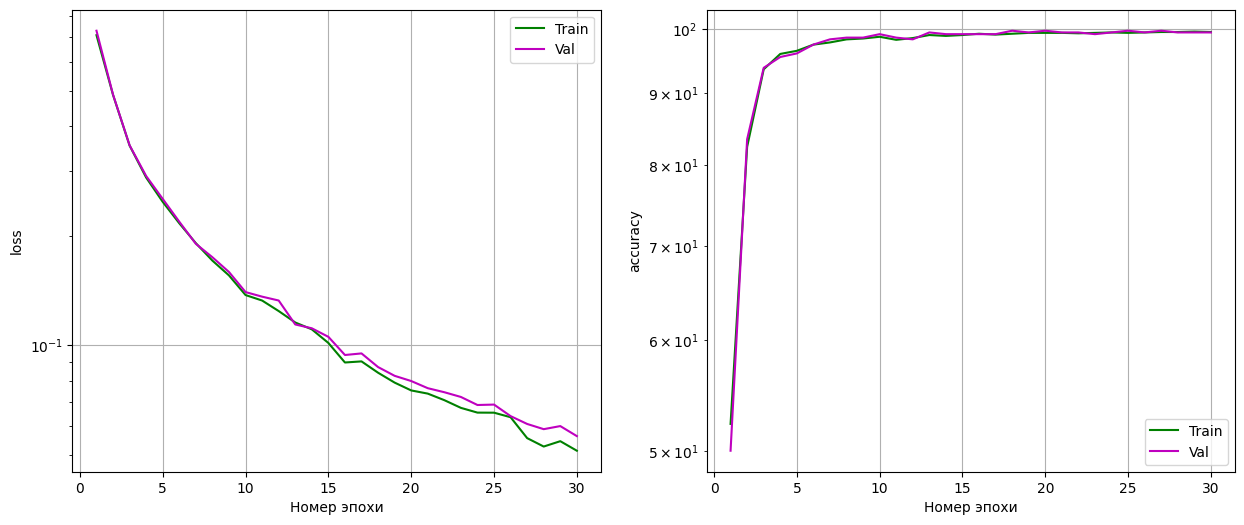

In [ ]:
transform = transforms.Compose(
    [
            transforms.RandomCrop(300),
            transforms.CenterCrop(224),
            # transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=255),
            transforms.ToTensor(),
    ])

pos_dataset, neg_dataset = pos_neg_dataset(CONF1, transform, pos_aug=40, neg_aug=4)

dataset = torch.utils.data.ConcatDataset([pos_dataset, neg_dataset])
seed_everything(CONF1.seed)
train_dataset, test_dataset = split_dataset(dataset)
common_train(CONF1, model, train_dataset, test_dataset, kind="cl")
load_best_model(CONF1, model, train_dataset, test_dataset, kind="cl")
logs = load_logs(CONF1.classifier.path_log)
graph_logs(logs, num=0)

Total:  0.9932432432432432


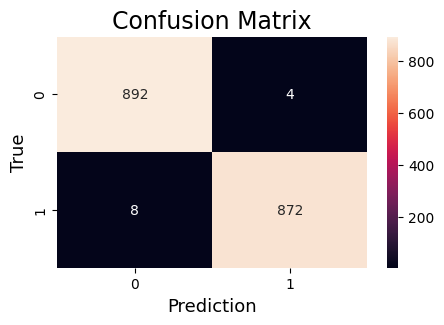

[[892   4]
 [  8 872]]
Positive:  0.990909090909091
Negative:  0.9955357142857143


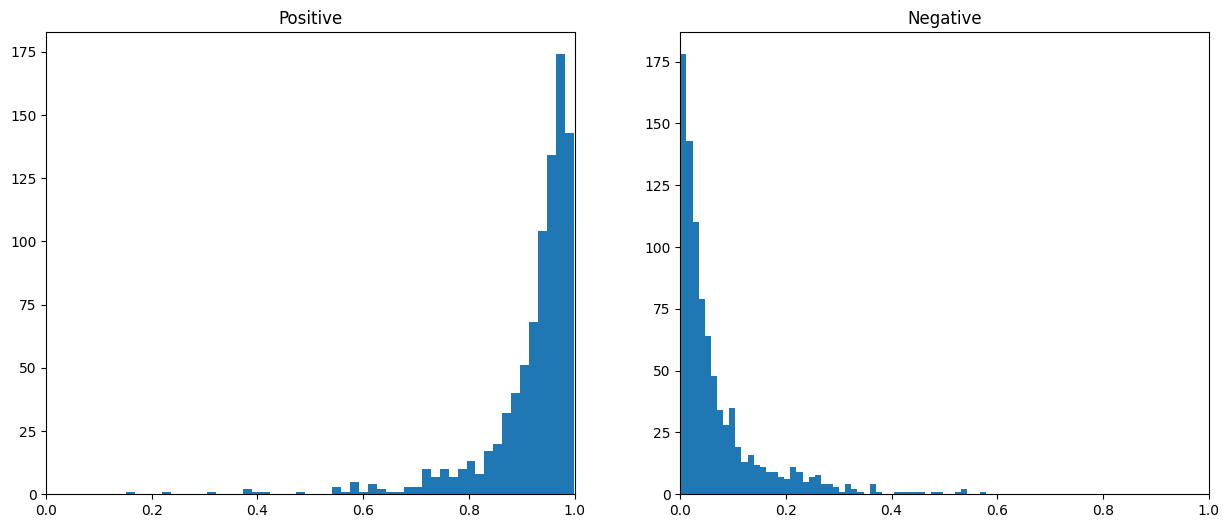

In [ ]:
X, y_true1, y_pred1, y_prob = get_predictions(model, dataset,
                                            CONF1.loader.batch_size, CONF1.device)
print("Total: ", accuracy_score(y_pred1, y_true1))
print(confusion_matrix(y_true1, y_pred1))

X, y_true2, y_pred2, y_prob2 = get_predictions(model, pos_dataset,
                                            CONF1.loader.batch_size, CONF1.device)
print("Positive: ", accuracy_score(y_pred2, y_true2))

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title("Positive")
distribution(y_prob2)

X, y_true3, y_pred3, y_prob3 = get_predictions(model, neg_dataset,
                                            CONF1.loader.batch_size, CONF1.device)
print("Negative: ", accuracy_score(y_pred3, y_true3))
plt.subplot(1, 2, 2)
plt.title("Negative")
distribution(y_prob3)
plt.show()

In [ ]:
X, y_true, y_pred, y_prob, indices = show_result(model, pos_dataset, 0.6,
                                   CONF1.loader.batch_size, CONF1.device,
                                   greater = False, col = 30,
                                   sort = True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
X, y_true, y_pred, y_prob, indices = show_result(model, neg_dataset, 0.3,
                                   CONF1.loader.batch_size, CONF1.device,
                                   greater = True, col = 24,
                                   sort = True)

Output hidden; open in https://colab.research.google.com to view.

# bin + classifier

In [ ]:
CONF1 = hydra_config("config (bin).yaml")
show_CONF(CONF1)

{
        "seed": 42,
        "device": "cpu",
        "save_path": "checkpoints",
        "dataset": {
                "data_pos": "bin/1",
                "data_neg": "bin/0",
                "threshold": 0.99
        },
        "loader": {
                "batch_size": 64
        },
        "classifier": {
                "n_epochs": 50,
                "learning_rate": 0.0003,
                "path_model": "checkpoints/bin",
                "path_log": "checkpoints/bin/bin.pickle"
        }
}


In [ ]:
transform = transforms.Compose(
    [
            transforms.Resize(500),
            transforms.RandomCrop(300),
            transforms.CenterCrop(224),
            # transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=255),
            transforms.ToTensor(),
    ])

pos_dataset, neg_dataset = pos_neg_dataset(CONF1, transform, pos_aug=40, neg_aug=4)

Positive dataset: 880    (22)
Доля белого больше у 111 картинки!!!
bin/0/2348-45.png
Доля белого больше у 132 картинки!!!
bin/0/37-16.png
Доля белого больше у 190 картинки!!!
bin/0/68-40.png
Доля белого больше у 335 картинки!!!
bin/0/2348-45.png
Доля белого больше у 356 картинки!!!
bin/0/37-16.png
Доля белого больше у 414 картинки!!!
bin/0/68-40.png
Доля белого больше у 559 картинки!!!
bin/0/2348-45.png
Доля белого больше у 638 картинки!!!
bin/0/68-40.png
Доля белого больше у 783 картинки!!!
bin/0/2348-45.png
Доля белого больше у 862 картинки!!!
bin/0/68-40.png
Negative dataset: 896    (224)


In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(CONF1.device)
num_classes = 2
num_non_freeze = 2050 # 2361346
seed_everything(CONF1.seed)
model = create_model(model, num_non_freeze, num_classes).to(CONF1.device)
print(f"num parameters ResNet = {number_of_parameters(model)}")

num parameters ResNet = 2050


Positive dataset: 880    (22)
Negative dataset: 896    (224)
split_dataset: Train: 1420 Test: 356 Total: 1776
train: started, kind = 'cl'
# 2024-06-04 11:15:13 Epoch  1 train/val: loss 0.69378/0.69747, acc: 52.887%/ 54.213%
# 2024-06-04 11:15:17 Epoch  2 train/val: loss 0.61697/0.62199, acc: 63.732%/ 64.607%
# 2024-06-04 11:15:22 Epoch  3 train/val: loss 0.54483/0.58065, acc: 73.662%/ 66.854%
# 2024-06-04 11:15:26 Epoch  4 train/val: loss 0.50148/0.55071, acc: 79.014%/ 69.944%
# 2024-06-04 11:15:31 Epoch  5 train/val: loss 0.48933/0.52532, acc: 80.211%/ 74.438%
# 2024-06-04 11:15:35 Epoch  6 train/val: loss 0.47188/0.50710, acc: 81.408%/ 75.281%
# 2024-06-04 11:15:39 Epoch  7 train/val: loss 0.44227/0.49148, acc: 82.606%/ 76.404%
# 2024-06-04 11:15:44 Epoch  8 train/val: loss 0.42800/0.47648, acc: 83.310%/ 76.685%
# 2024-06-04 11:15:48 Epoch  9 train/val: loss 0.43467/0.48722, acc: 82.113%/ 73.876%
# 2024-06-04 11:15:52 Epoch 10 train/val: loss 0.41404/0.47556, acc: 83.099%/ 75.843%
# 

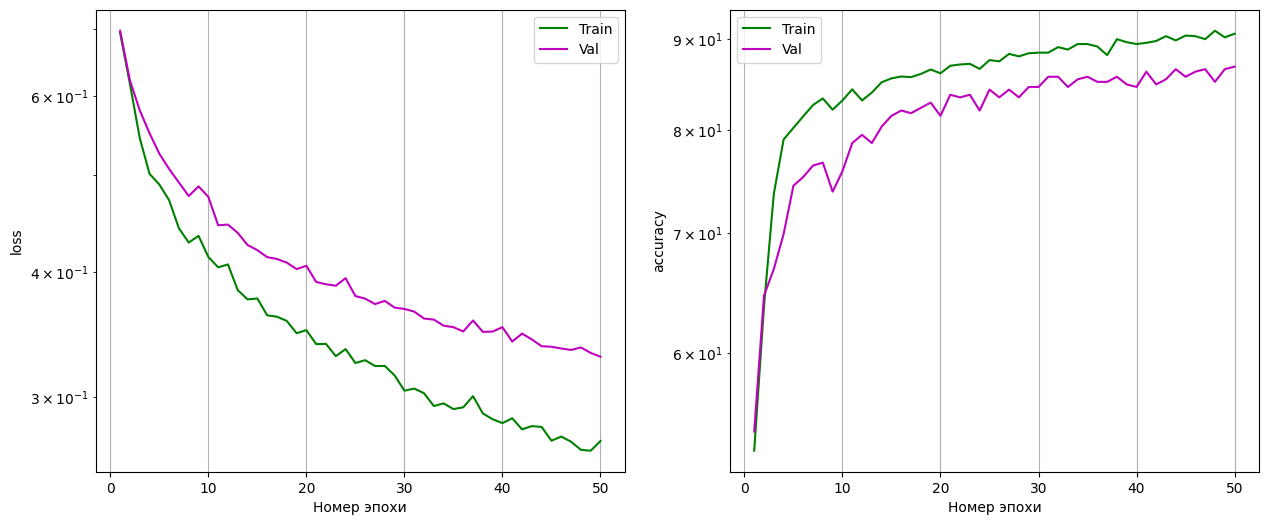

In [ ]:
transform = transforms.Compose(
    [
            transforms.RandomCrop(300),
            transforms.CenterCrop(224),
            # transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=255),
            transforms.ToTensor(),
    ])

pos_dataset, neg_dataset = pos_neg_dataset(CONF1, transform, pos_aug=40, neg_aug=4)

dataset = torch.utils.data.ConcatDataset([pos_dataset, neg_dataset])
seed_everything(CONF1.seed)
train_dataset, test_dataset = split_dataset(dataset)
common_train(CONF1, model, train_dataset, test_dataset, kind="cl")
load_best_model(CONF1, model, train_dataset, test_dataset, kind="cl")
logs = load_logs(CONF1.classifier.path_log)
graph_logs(logs, num=0)

Total:  0.8980855855855856


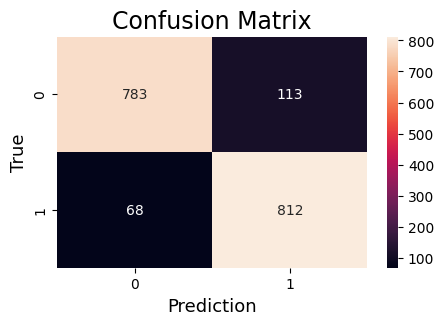

[[783 113]
 [ 68 812]]
Positive:  0.9227272727272727
Negative:  0.8738839285714286


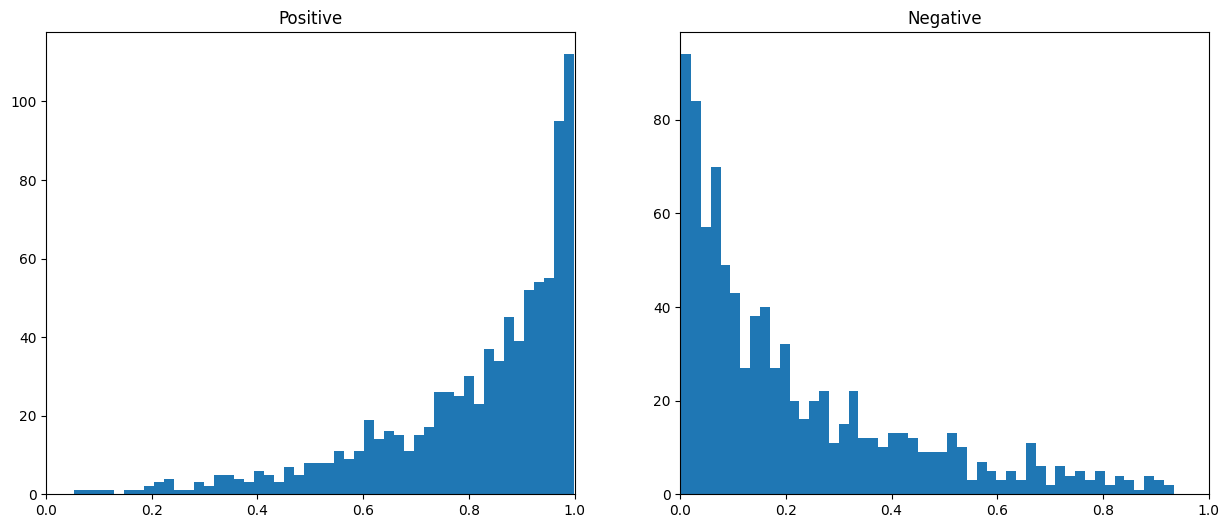

In [ ]:
X, y_true1, y_pred1, y_prob = get_predictions(model, dataset,
                                            CONF1.loader.batch_size, CONF1.device)
print("Total: ", accuracy_score(y_pred1, y_true1))
print(confusion_matrix(y_true1, y_pred1))

X, y_true2, y_pred2, y_prob2 = get_predictions(model, pos_dataset,
                                            CONF1.loader.batch_size, CONF1.device)
print("Positive: ", accuracy_score(y_pred2, y_true2))

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title("Positive")
distribution(y_prob2)

X, y_true3, y_pred3, y_prob3 = get_predictions(model, neg_dataset,
                                            CONF1.loader.batch_size, CONF1.device)
print("Negative: ", accuracy_score(y_pred3, y_true3))
plt.subplot(1, 2, 2)
plt.title("Negative")
distribution(y_prob3)
plt.show()

In [ ]:
X, y_true, y_pred, y_prob, indices = show_result(model, pos_dataset, 0.6,
                                   CONF1.loader.batch_size, CONF1.device,
                                   greater = False, col = 30,
                                   sort = True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
X, y_true, y_pred, y_prob, indices = show_result(model, neg_dataset, 0.3,
                                   CONF1.loader.batch_size, CONF1.device,
                                   greater = True, col = 50,
                                   sort = True)

Output hidden; open in https://colab.research.google.com to view.

# siamese

In [6]:
CONF1 = hydra_config("config (siam).yaml")
show_CONF(CONF1)

{
        "seed": 42,
        "device": "cuda",
        "save_path": "checkpoints",
        "dataset": {
                "data_pos": "bin/1",
                "data_neg": "bin/0",
                "threshold": 0.9
        },
        "loader": {
                "batch_size": 64
        },
        "siamese": {
                "n_epochs": 50,
                "learning_rate": 0.0003,
                "margin": 9,
                "path_model": "checkpoints/siamese",
                "path_log": "checkpoints/siamese/siamese.pickle"
        },
        "classifier": {
                "n_epochs": 30,
                "learning_rate": 0.0003,
                "path_model": "checkpoints/classifier",
                "path_log": "checkpoints/classifier/classifier.pickle"
        }
}


In [ ]:
siam = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(CONF1.device)
num_classes = 1000
num_non_freeze = 513000 #
seed_everything(CONF1.seed)
siam = create_model(siam, num_non_freeze, num_classes, verbose=False).to(CONF1.device)
print(f"num parameters ResNet = {number_of_parameters(siam)}")

num parameters ResNet = 513000


Positive dataset: 880    (22)
Доля белого больше у 111 картинки!!!
bin/0/2348-45.png
Доля белого больше у 132 картинки!!!
bin/0/37-16.png
Доля белого больше у 190 картинки!!!
bin/0/68-40.png
Доля белого больше у 335 картинки!!!
bin/0/2348-45.png
Доля белого больше у 356 картинки!!!
bin/0/37-16.png
Доля белого больше у 414 картинки!!!
bin/0/68-40.png
Доля белого больше у 559 картинки!!!
bin/0/2348-45.png
Доля белого больше у 638 картинки!!!
bin/0/68-40.png
Доля белого больше у 783 картинки!!!
bin/0/2348-45.png
Доля белого больше у 862 картинки!!!
bin/0/68-40.png
Negative dataset: 896    (224)
split_dataset: Train: 8000 Test: 2000 Total: 10000
train: started, kind = 'siam'
# 2024-06-04 12:20:25 Epoch  1 train/val: loss 2.87952/3.04972, acc: 94.625%/ 94.950%
# 2024-06-04 12:21:19 Epoch  2 train/val: loss 1.67151/1.85265, acc: 97.050%/ 96.850%
# 2024-06-04 12:22:12 Epoch  3 train/val: loss 1.22412/1.40551, acc: 98.037%/ 97.900%
# 2024-06-04 12:23:06 Epoch  4 train/val: loss 0.95562/1.13911

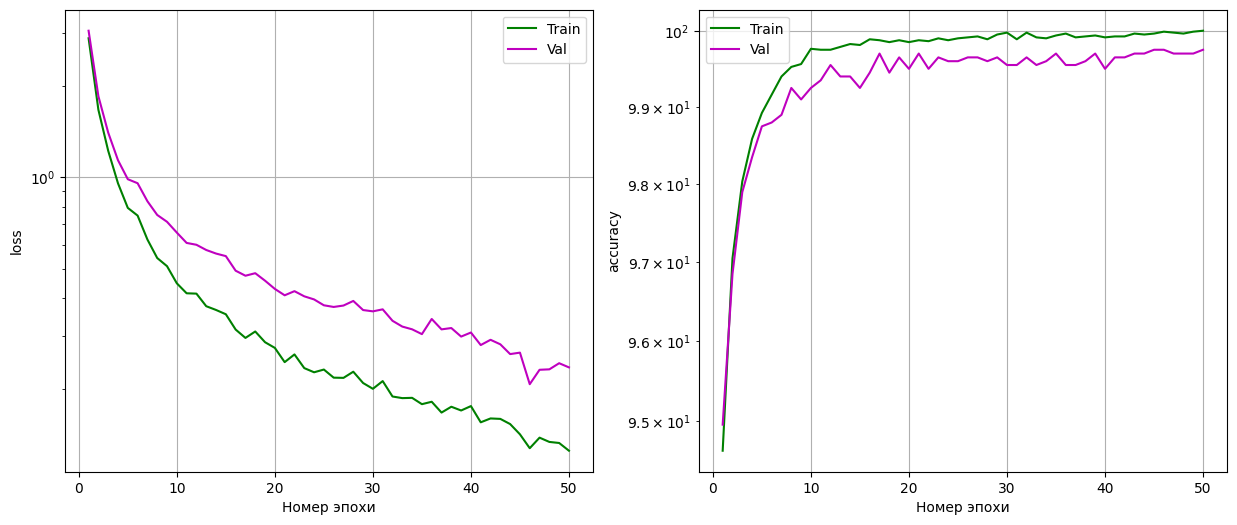

In [ ]:
transform = transforms.Compose(
    [
            transforms.Resize(500),
            transforms.RandomCrop(300),
            transforms.CenterCrop(224),
            transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=255),
            transforms.ToTensor(),
    ])

pos_dataset, neg_dataset = pos_neg_dataset(CONF1, transform, pos_aug=40, neg_aug=4)

dataset_tri = TripletDataset(
        pos_dataset, neg_dataset, required_len=10_000, deterministic=True, seed=CONF1.seed
    )
seed_everything(CONF1.seed)
train_dataset, test_dataset = split_dataset(dataset_tri)
common_train(CONF1, siam, train_dataset, test_dataset, kind="siam")
load_best_model(CONF1, siam, train_dataset, test_dataset, kind="siam")
logs = load_logs(CONF1.siamese.path_log)
graph_logs(logs, num=0)

num parameters = 513538
split_dataset: Train: 1420 Test: 356 Total: 1776
train: started, kind = 'cl'
# 2024-06-04 13:05:02 Epoch  1 train/val: loss 0.25076/0.32950, acc: 89.789%/ 85.674%
# 2024-06-04 13:05:12 Epoch  2 train/val: loss 0.12574/0.18229, acc: 96.901%/ 94.101%
# 2024-06-04 13:05:22 Epoch  3 train/val: loss 0.10106/0.16770, acc: 97.113%/ 94.101%
# 2024-06-04 13:05:32 Epoch  4 train/val: loss 0.07270/0.13910, acc: 98.521%/ 94.382%
# 2024-06-04 13:05:42 Epoch  5 train/val: loss 0.05427/0.12463, acc: 99.155%/ 94.944%
# 2024-06-04 13:05:52 Epoch  6 train/val: loss 0.04288/0.12206, acc: 99.296%/ 94.944%
# 2024-06-04 13:06:01 Epoch  7 train/val: loss 0.05770/0.10945, acc: 98.803%/ 95.225%
# 2024-06-04 13:06:11 Epoch  8 train/val: loss 0.02672/0.11488, acc: 99.718%/ 95.225%
# 2024-06-04 13:06:22 Epoch  9 train/val: loss 0.02267/0.09345, acc: 99.718%/ 96.348%
# 2024-06-04 13:06:32 Epoch 10 train/val: loss 0.02049/0.12191, acc: 99.859%/ 94.663%
# 2024-06-04 13:06:41 Epoch 11 train/va

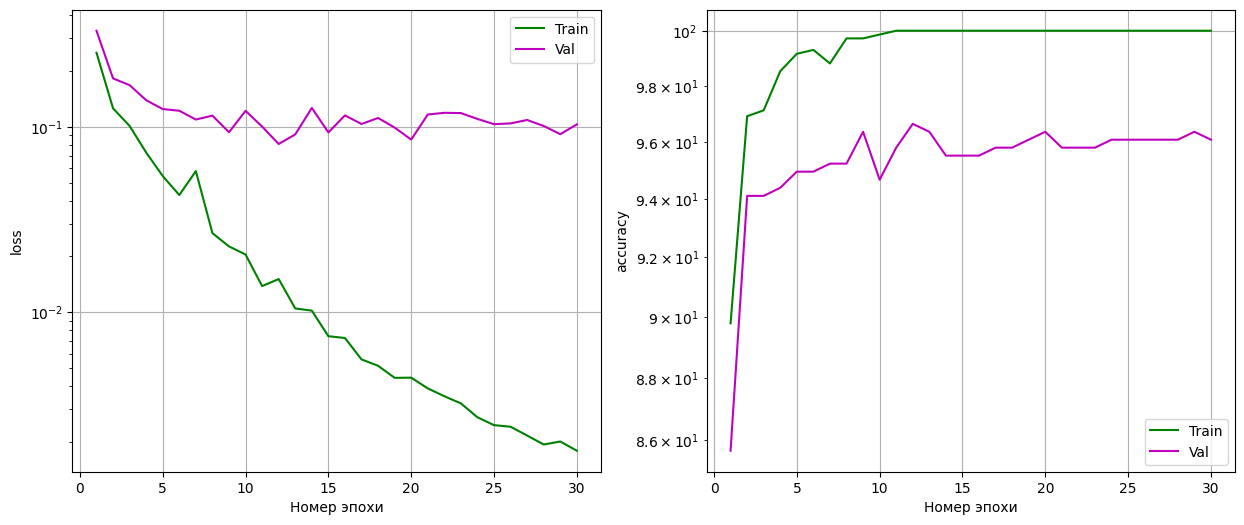

In [ ]:
cl = nn.Sequential(nn.Linear(num_classes, 512), nn.ReLU(), nn.Linear(512, 2)).to(
    CONF1.device
)
num_param = number_of_parameters(cl)
print(f"num parameters = {num_param}")

dataset = torch.utils.data.ConcatDataset([pos_dataset, neg_dataset])
dataset_emb = Emb_Dataset(siam, dataset, CONF1.device)
seed_everything(CONF1.seed)
train_dataset, test_dataset = split_dataset(dataset_emb)

common_train(CONF1, cl, train_dataset, test_dataset, kind="cl")
load_best_model(CONF1, cl, train_dataset, test_dataset, kind="cl")
logs = load_logs(CONF1.classifier.path_log)
graph_logs(logs, num=0)

model = Pipeline(siam, cl)

Total:  0.9932432432432432


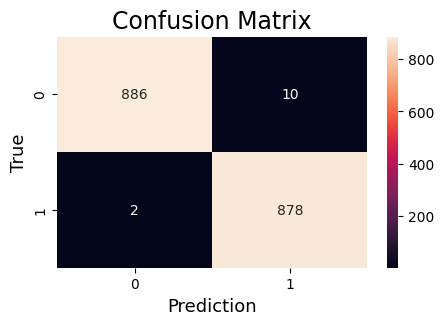

[[886  10]
 [  2 878]]
Positive:  0.9977272727272727
Negative:  0.9888392857142857


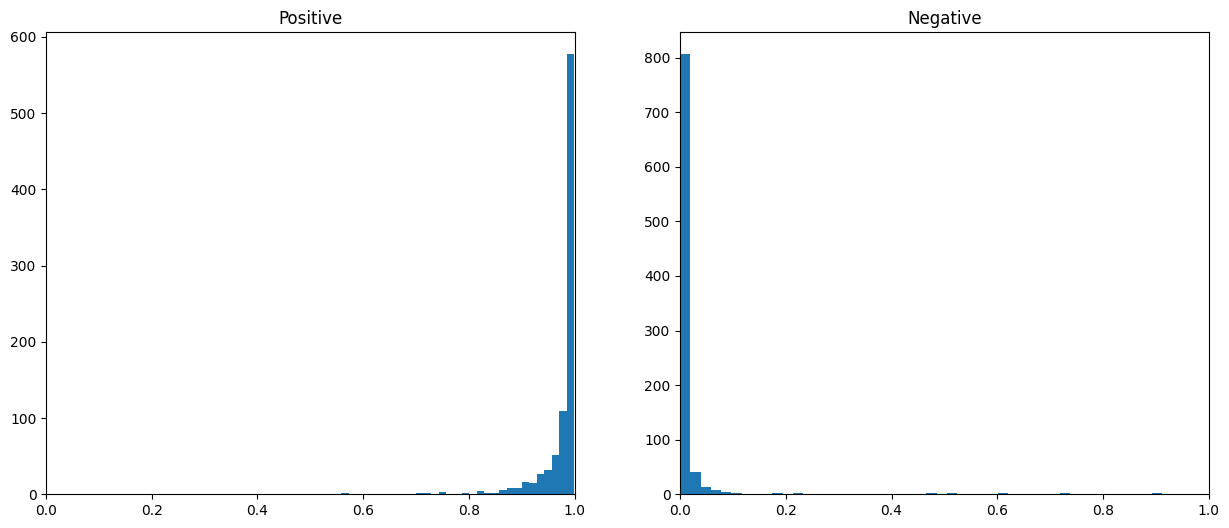

In [ ]:
X, y_true1, y_pred1, y_prob = get_predictions(model, dataset,
                                            CONF1.loader.batch_size, CONF1.device)
print("Total: ", accuracy_score(y_pred1, y_true1))
print(confusion_matrix(y_true1, y_pred1))

X, y_true2, y_pred2, y_prob2 = get_predictions(model, pos_dataset,
                                            CONF1.loader.batch_size, CONF1.device)
print("Positive: ", accuracy_score(y_pred2, y_true2))

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.title("Positive")
distribution(y_prob2)

X, y_true3, y_pred3, y_prob3 = get_predictions(model, neg_dataset,
                                            CONF1.loader.batch_size, CONF1.device)
print("Negative: ", accuracy_score(y_pred3, y_true3))
plt.subplot(1, 2, 2)
plt.title("Negative")
distribution(y_prob3)
plt.show()

prob < 0.6
count : 5 out of 880
pic idx : [709, 340, 796, 344, 561]


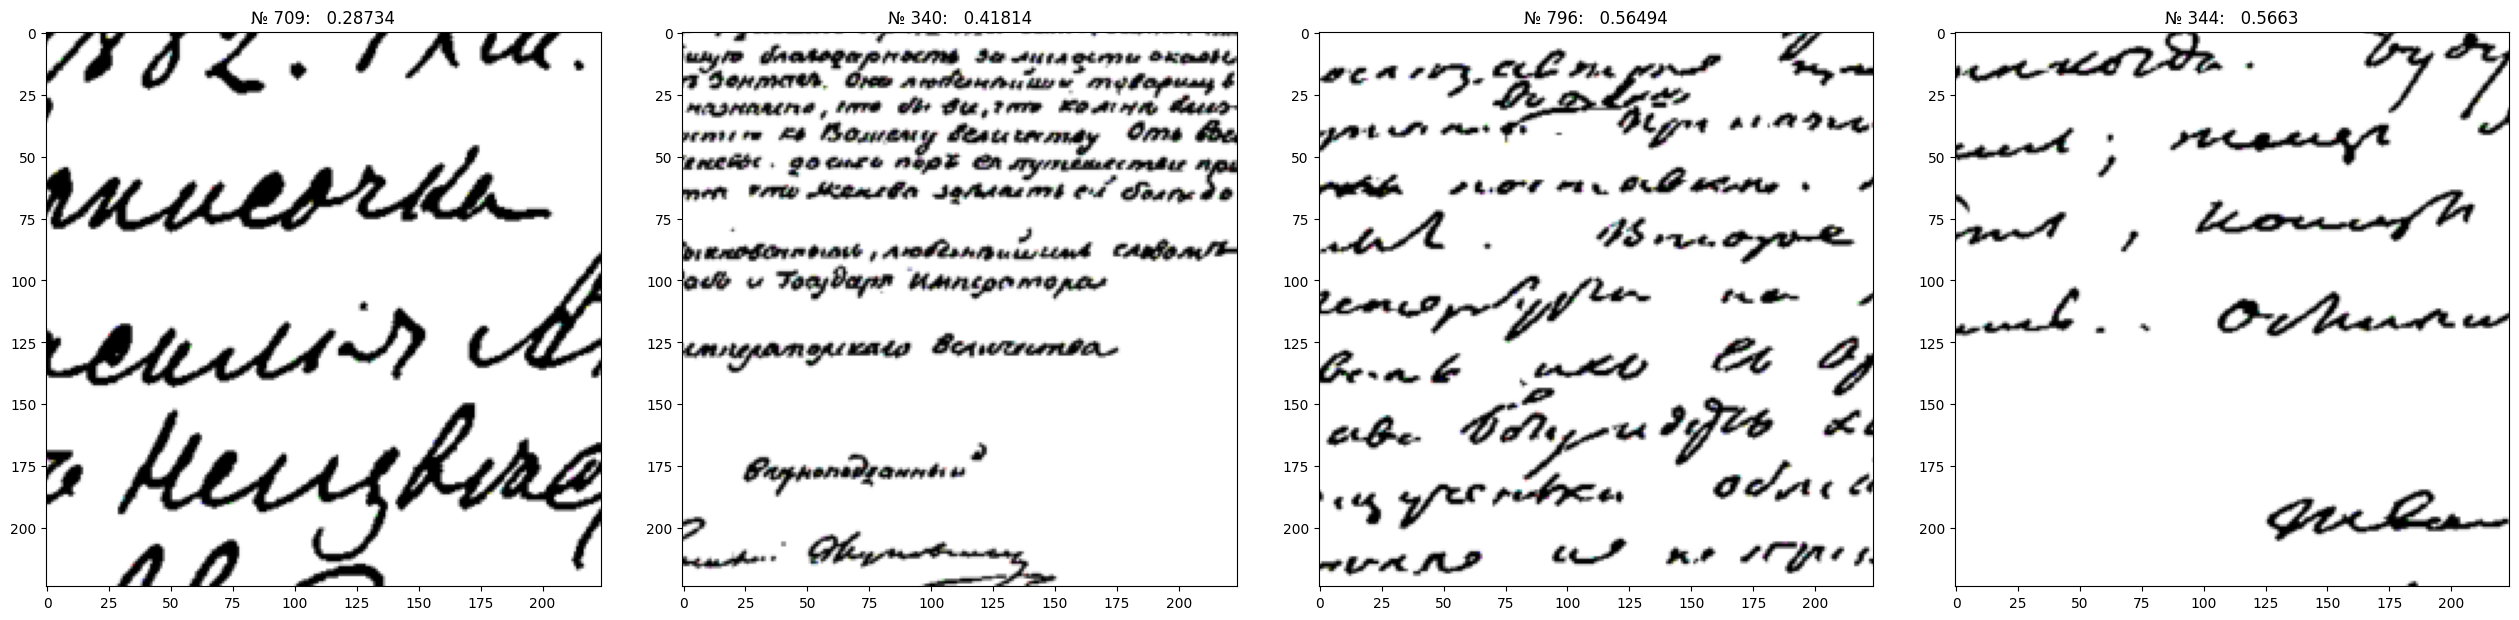

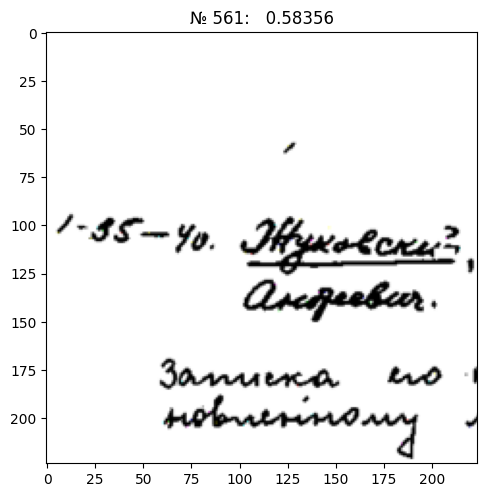

In [ ]:
X, y_true, y_pred, y_prob, indices = show_result(model, pos_dataset, 0.6,
                                   CONF1.loader.batch_size, CONF1.device,
                                   greater = False, col = 30,
                                   sort = True)

In [ ]:
X, y_true, y_pred, y_prob, indices = show_result(model, neg_dataset, 0.3,
                                   CONF1.loader.batch_size, CONF1.device,
                                   greater = True, col = 24,
                                   sort = True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
X, y_true, y_pred, y_prob, indices = show_result(model, neg_dataset, 0,
                                   CONF1.loader.batch_size, CONF1.device,
                                   greater = True, col = None,
                                   sort = True)

Output hidden; open in https://colab.research.google.com to view.

# AIM

In [10]:
# PATH = 'dataset'
# NEW_PATH = 'dataset_min'

# if not os.path.exists(NEW_PATH):
#     os.makedirs(NEW_PATH)

# for i in sorted(os.listdir(PATH)):
#     path = os.path.join(PATH, i)
#     list_pic = sorted(os.listdir(path))
#     if len(list_pic) > 5:
#         print(path, len(list_pic))

In [11]:
# PATH = 'dataset'
# NEW_PATH = 'dataset_min'

# if not os.path.exists(NEW_PATH):
#     os.makedirs(NEW_PATH)

# for i in sorted(os.listdir(NEW_PATH)):
#     path = os.path.join(NEW_PATH, i)
#     list_pic = sorted(os.listdir(path))
#     if len(list_pic) > 5:
#         print(path, len(list_pic))

In [20]:
from functools import partial

top = 610
bottom = 740
crop = partial(v2.functional.crop,
               top = top, left = 0, height = 3542 - top - bottom, width = 2479)

dataset = datasets.ImageFolder('AIM', transform=transforms.Compose(
        [   transforms.ToTensor(),
            v2.functional.grayscale_to_rgb,
            crop,
            transforms.Resize(500),
        ]))

torch.save(dataset, 'aim.pt')

In [21]:
dataset = torch.load('aim.pt')

In [22]:
# for i, j in dataset:
#     print(i.shape, j)

In [19]:
class TripletMultiDataset(Dataset):
    def __init__(self, images_dir, required_len, min_col=5, deterministic=True, seed=42):
        self.images_dir = images_dir
        self.required_len = required_len
        self.deterministic = deterministic

        self.dirs = []

        for i in sorted(os.listdir(images_dir)):
            path = os.path.join(images_dir, i)
            list_pic = sorted(os.listdir(path))
            if len(list_pic) > min_col:
                self.dirs.append(path)

        self.transform = transforms.Compose(
            [   v2.functional.grayscale_to_rgb,
                transforms.Resize(500),
                transforms.RandomCrop(300),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )

        if self.deterministic:
            seed_everything(seed)
            self.X = []
            for i in tqdm(range(self.required_len)):

                idx = random.randrange(len(self.dirs))
                dir = self.dirs[idx]
                files = os.listdir(dir)

                anchor, positive = random.sample(files, 2)
                anchor, positive = os.path.join(dir, anchor), os.path.join(dir, positive)

                dirs = self.dirs[:idx] + self.dirs[idx+1:]
                dir = random.choice(dirs)
                files = os.listdir(dir)
                negative = os.path.join(dir, random.choice(files))


                l = [anchor, positive, negative]

                # print(l)
                for i, path in enumerate(l):
                    image = Image.open(path)
                    l[i] = self.transform(image)

                self.X.append(l)


    def __len__(self):
        return self.required_len

    def __getitem__(self, idx):
        if idx < len(self):

            if self.deterministic:
                return self.X[idx]
            else:
                pass
        else:
            raise IndexError

In [20]:
tripletdataset = TripletMultiDataset("dataset", required_len=10_000)

torch.save(tripletdataset, 'dataset.pt')

 18%|█▊        | 1770/10000 [01:24<06:33, 20.90it/s]


KeyboardInterrupt: 